In [1]:
%%html
<style>.container {width: 80% !important;}</style>

In [2]:
import os
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import gc

# Utils

In [3]:
def flush():
  gc.collect()
  torch.cuda.empty_cache()

## Download Caravana dataset from kegel and we are going to play witht the train and train_mask currently

## Parameters

In [4]:
CURRENT_DIR = os.getcwd()
IMAGES_DIR = "data/carvana_dataset/train"
MASKS_DIR = "data/carvana_dataset/train_masks"

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 3
N_CLASSES = 21
device = "cuda" if torch.cuda.is_available() else "cpu"

## Set Images directory

In [5]:
# get images from the directories
images_list = os.listdir(IMAGES_DIR)
masks_list = os.listdir(MASKS_DIR)

# sort the images and masks so that each index have the same mask against the image
images_list = sorted(images_list)
masks_list = sorted(masks_list)

# get complete path of images and masks
images_list = [f"{IMAGES_DIR}/{im}" for im in images_list]
masks_list = [f"{MASKS_DIR}/{im}" for im in masks_list]

## Show some  images and there masks

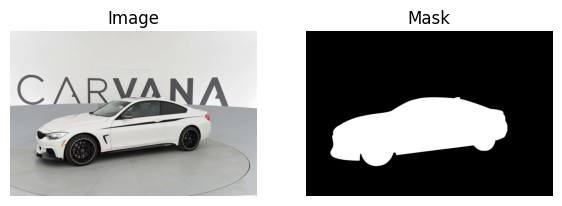

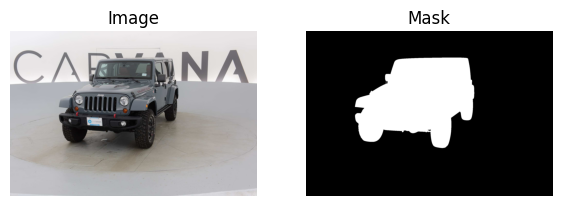

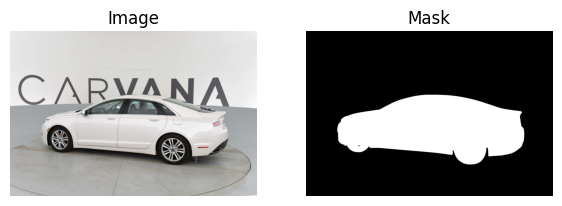

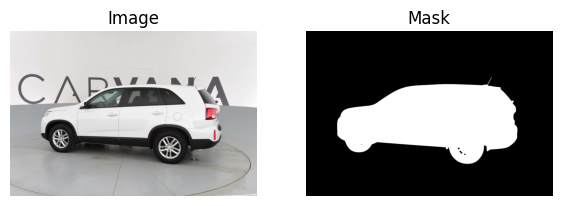

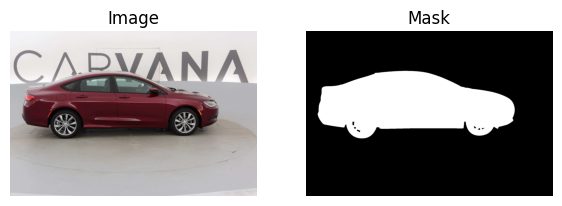

In [6]:
def show_images(img_list, msk_list, num_of_images = 6):
    
    if len(img_list) != len(msk_list):
        print(f"images length {len(img_list)} is not equal to masks length {len(msk_list)}")
        return
    
    rand_ids = np.random.randint(0, len(img_list), num_of_images)
    for index in rand_ids:
        image_path, mask_path = img_list[index], msk_list[index]
        img, mask = Image.open(image_path), Image.open(mask_path)
        fig, axis = plt.subplots(1,2, figsize = (7, 4))
        axis[0].imshow(img)
        axis[0].set_title("Image")
        axis[1].imshow(mask)
        axis[1].set_title("Mask")
        for ax in axis:
            ax.axis("off")        
    
show_images(images_list, masks_list, 5)

## Data Augmentation

In [7]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.0, 0.0, 0.0],std=[1.0, 1.0, 1.0],max_pixel_value=255.0),
    ToTensorV2()])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2()])

# Creating Dataset

In [8]:
class CarvanaDataset(Dataset):
    def __init__(self, image_list, mask_list, transform =None):
        self.images = image_list
        self.masks = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        mask[mask==255.0] = 1.0
        
        if self.transform is not None:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation['image']
            mask = augmentation['mask']
        
        return image, mask

## Split Images into train, val sets

In [9]:
train_images, val_images, train_masks, val_masks = train_test_split(images_list, masks_list, test_size=0.2, random_state=42)

In [10]:
train_dataset = CarvanaDataset(train_images, train_masks, transform=train_transform)
val_dataset = CarvanaDataset(val_images, val_masks, transform=val_transform)

## DataLoader

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
img, mask = train_dataset[5]
img.shape

torch.Size([3, 224, 224])

In [13]:
print(mask.shape)
mask[100]

torch.Size([224, 224])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

# Create Segmentation Unet Model

In [14]:
class UNetModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        
        # Encoding/Contracting path
        self.conv1 = self.double_conv(3, 64)
        self.conv2 = self.double_conv(64, 128)
        self.conv3 = self.double_conv(128, 256)
        self.conv4 = self.double_conv(256, 512)
        self.conv5 = self.double_conv(512, 1024)
        
        # Decoding / Expansion path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.deconv4 = self.double_conv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.deconv3 = self.double_conv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.deconv2 = self.double_conv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.deconv1 = self.double_conv(128, 64)
        
        self.out_layer = nn.Conv2d(in_channels=64, out_channels=n_classes, kernel_size=1)
        
        
    def double_conv(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def concat(self, x1, x2):
        
        diffX = x1.shape[2] - x2.shape[2]
        diffY = x1.shape[3] - x2.shape[3]
        
        padding_left = diffX // 2
        paddin_right = diffX - padding_left
        
        padding_top = diffY // 2
        padding_bottom = diffY - padding_top
        
        x2 = F.pad(x2, (padding_left, paddin_right, padding_top, padding_bottom))
        x_concat = torch.cat((x1,x2),dim=1)
        return x_concat
        

        
    def forward(self, x):
        x1 = self.conv1(x)  
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2)) 
        x4 = self.conv4(self.maxpool(x3))
        x5 = self.conv5(self.maxpool(x4))
        
        x4_up = self.upconv4(x5) 
        x4_up = self.concat(x4, x4_up)
        x4_up = self.deconv4(x4_up)
        
        x3_up = self.upconv3(x4_up)
        x3_up = self.concat(x3, x3_up)
        x3_up = self.deconv3(x3_up)
        
        x2_up = self.upconv2(x3_up)
        x2_up = self.concat(x2, x2_up)
        x2_up = self.deconv2(x2_up)
        
        
        x1_up = self.upconv1(x2_up)
        x1_up = self.concat(x1, x1_up)
        x1_up = self.deconv1(x1_up)
        
        output = self.out_layer(x1_up)
        output = F.interpolate(output, size=(IMAGE_HEIGHT, IMAGE_WIDTH), mode='bilinear', align_corners=True)
        
        return output
    



## Test model

In [15]:
model = UNetModel(1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



# test for errors
x = torch.randn((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
x = x.to(device)
pred = model(x)
print(pred.shape)
summary(model=model, input_size=(3, IMAGE_HEIGHT, IMAGE_WIDTH))

torch.Size([1, 1, 224, 224])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
       BatchNorm2d-2         [-1, 64, 222, 222]             128
              ReLU-3         [-1, 64, 222, 222]               0
            Conv2d-4         [-1, 64, 220, 220]          36,928
       BatchNorm2d-5         [-1, 64, 220, 220]             128
              ReLU-6         [-1, 64, 220, 220]               0
         MaxPool2d-7         [-1, 64, 110, 110]               0
            Conv2d-8        [-1, 128, 108, 108]          73,856
       BatchNorm2d-9        [-1, 128, 108, 108]             256
             ReLU-10        [-1, 128, 108, 108]               0
           Conv2d-11        [-1, 128, 106, 106]         147,584
      BatchNorm2d-12        [-1, 128, 106, 106]             256
             ReLU-13        [-1, 128, 106, 106]               0
        Ma

## Load Mode if needed

In [16]:
# checkpoint = torch.load("cnnmodel.pth.tar")
# model.load_state_dict(checkpoint["state_dict"])

# Training and evaluation

In [17]:
# Training Function
def train_one_epoch(model, train_loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (images, targets) in enumerate(train_bar):
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{train_loss / (batch_idx + 1):.3f}'})
    return train_loss / len(train_loader)

In [18]:
# Validation Loop
def validate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    val_bar = tqdm(test_loader, desc='Validating')
    with torch.no_grad():
        for images, targets in val_bar:
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = model(images)
            predicted = torch.sigmoid(outputs)
            predicted = (predicted > 0.5).float()
            total_correct += (predicted == targets).sum().item()
            total_pixels += targets.nelement()
    return total_correct / total_pixels * 100

In [19]:
def plot_results(train_losses, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'b-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

Epoch 1/3


Training: 100%|█████████████████| 1018/1018 [07:27<00:00,  2.27it/s, loss=0.125]


Training Loss: 0.125


Validating: 100%|█████████████████████████████| 255/255 [01:20<00:00,  3.17it/s]


Validation Accuracy: 99.00%
Epoch 2/3


Training: 100%|█████████████████| 1018/1018 [05:37<00:00,  3.01it/s, loss=0.041]


Training Loss: 0.041


Validating: 100%|█████████████████████████████| 255/255 [00:49<00:00,  5.20it/s]


Validation Accuracy: 99.14%
Epoch 3/3


Training: 100%|█████████████████| 1018/1018 [05:43<00:00,  2.96it/s, loss=0.028]


Training Loss: 0.028


Validating: 100%|█████████████████████████████| 255/255 [00:51<00:00,  4.94it/s]


Validation Accuracy: 99.28%


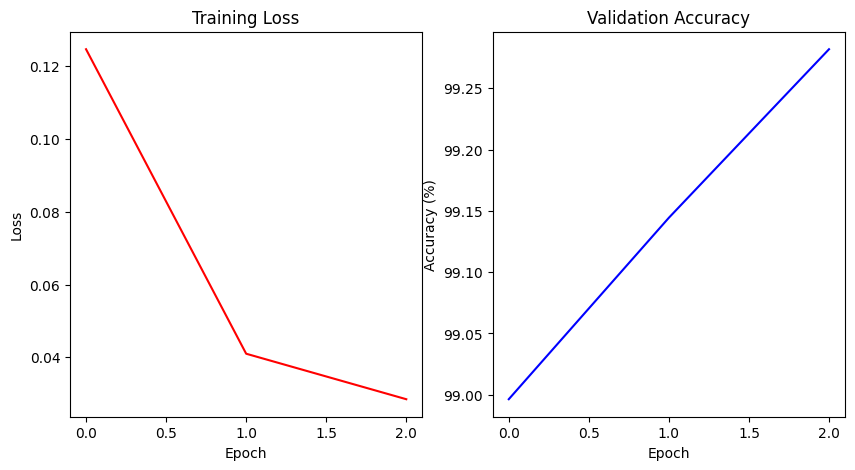

In [20]:
num_epochs = 3
train_losses = []
val_accuracies = []

for epoch in range(num_epochs ):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')

    accuracy = validate(model, val_loader, device)
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')

plot_results(train_losses, val_accuracies)

## Same Model if needed

In [23]:
# checkpoint = {
#             "state_dict": model.state_dict(),
#             "optimizer":optimizer.state_dict(),
#         }
# torch.save(checkpoint, "unet_cnn_carvana.pth.tar")

# Show some Images with the predicted model

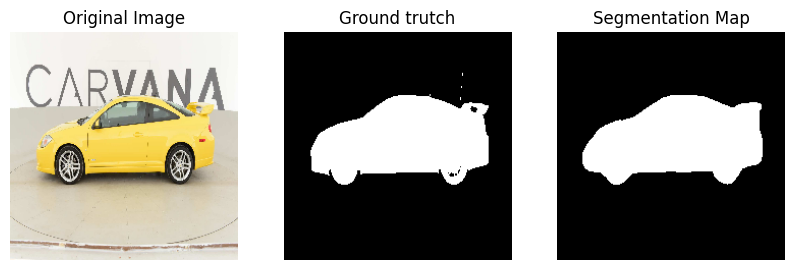

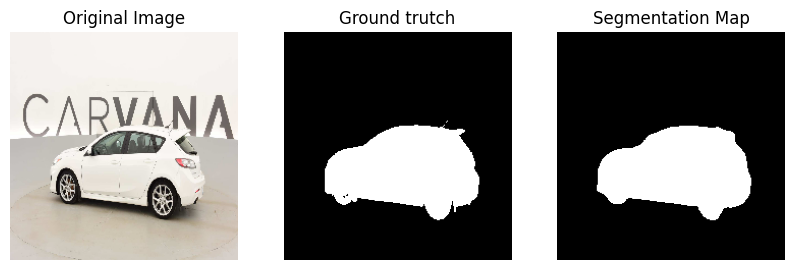

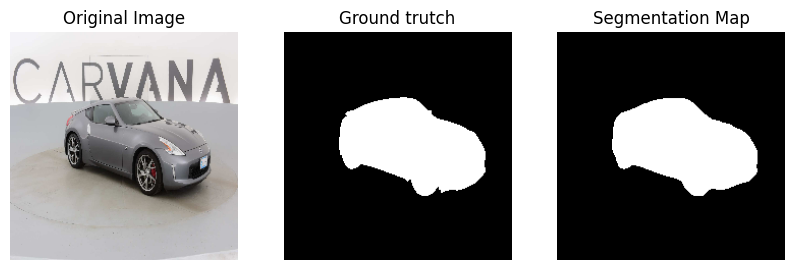

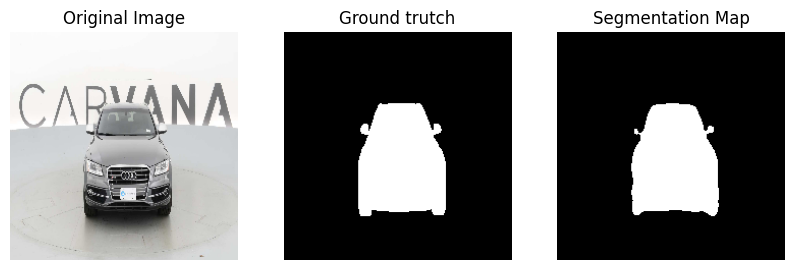

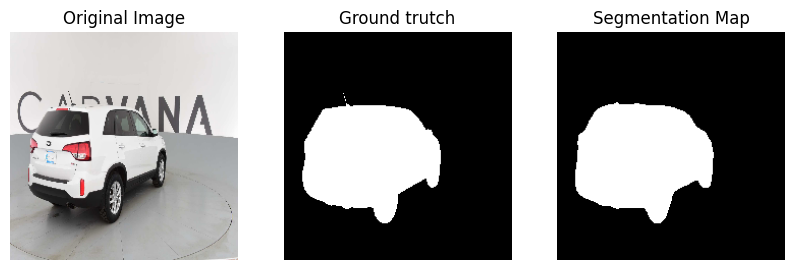

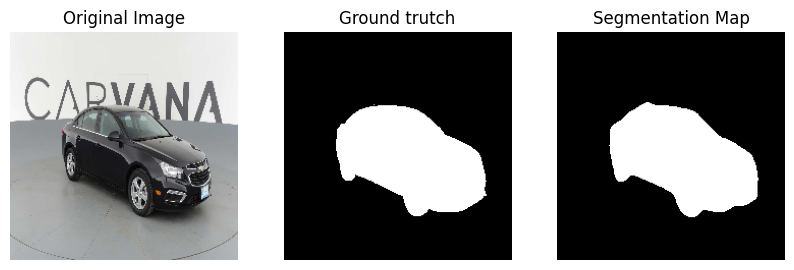

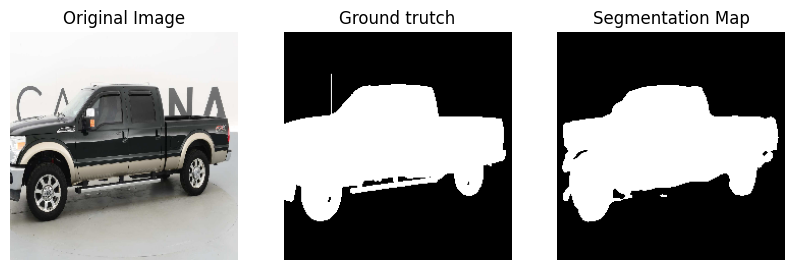

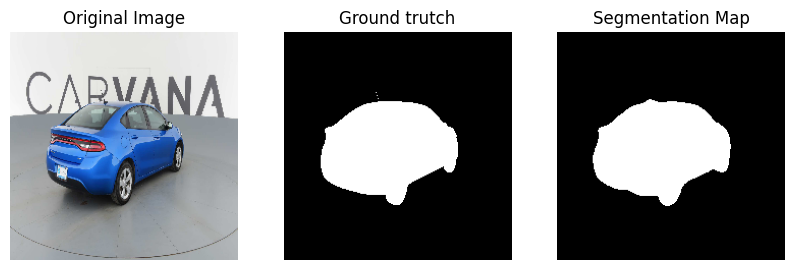

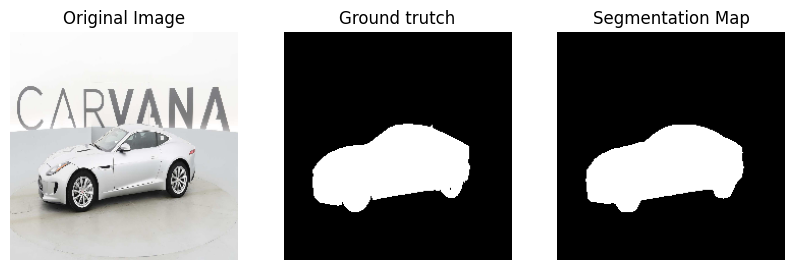

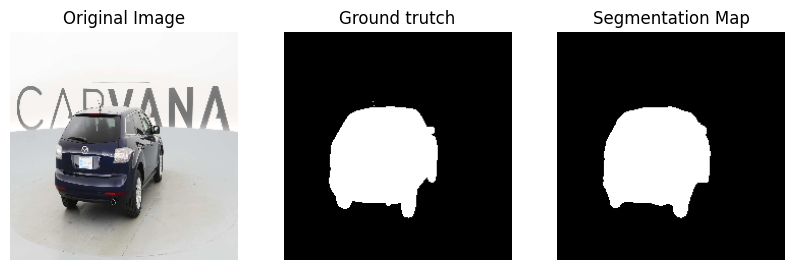

In [22]:
rand_ids = np.random.randint(1,len(val_dataset), 10)

model.eval()
with torch.no_grad():
    for id in rand_ids:
        image, mask = val_dataset[id]
        image = image.to(device).unsqueeze(0)     
        preds = model(image)
        preds = (preds > 0.5)
        seg_map = preds.squeeze().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))  
        
        image = image.squeeze().permute(1,2,0)
        image = image.cpu().numpy()
        
        axs[0].imshow(image)
        axs[0].title.set_text('Original Image')
        
        axs[1].imshow(mask,cmap='gray')
        axs[1].title.set_text('Ground trutch')
        
        axs[2].imshow(seg_map,cmap='gray')
        axs[2].title.set_text('Segmentation Map')
        
        for ax in axs:
            ax.axis("off")
        plt.show()